In [1]:
import numpy as np
import pandas as pd
import scipy as sc

from importlib import reload
from time import time
import matplotlib

import utils

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

## Load data

In [2]:
# load data with PTM labels and ground-truth and predicted disorder labels
# processed in process-data-and-train-model.ipynb
ptm_idr_df = pd.read_csv('data/ptm_idr.csv')
ptm_idr_df

,protein_id,AA,position,ac,ac_reg,ga,gl,gl_reg,m,m_reg,...,nAA_28_180_pae_smooth5,nAA_28_180_pae_smooth10,nAA_28_180_pae_smooth15,nAA_28_180_pae_smooth20,nAA_28_180_pae_smooth25,nAA_28_180_pae_smooth30,nAA_28_180_pae_smooth35,disordered,ordered,pred_disordered
0,O00151,K,22,1,0,0,0,0,0,0,...,72.818182,77.428571,74.774194,74.951220,75.319149,76.500000,76.877193,0.0,1.0,0.022424
1,O00151,K,71,0,0,0,0,0,0,0,...,75.000000,77.809524,72.483871,67.268293,64.294118,61.786885,59.450704,0.0,1.0,0.057403
2,O00151,K,87,0,0,0,0,0,1,0,...,33.000000,41.095238,41.419355,43.170732,43.764706,43.491803,44.070423,0.0,1.0,0.245860
3,O00151,T,34,0,0,0,0,0,0,0,...,80.727273,78.380952,79.193548,80.560976,77.980392,77.754098,76.695652,0.0,1.0,0.017603
4,O00168,S,82,0,0,0,0,0,0,0,...,18.454545,16.761905,16.384615,16.806452,17.638889,19.756098,22.000000,0.0,1.0,0.433978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10797,Q9Y6W3,S,697,0,0,0,0,0,0,0,...,101.818182,105.047619,103.870968,113.097561,115.352941,124.655738,129.366197,0.0,1.0,0.006763
10798,Q9Y6W3,S,700,0,0,0,0,0,0,0,...,93.454545,98.857143,102.258065,110.756098,110.725490,121.901639,129.845070,0.0,1.0,0.006944
10799,Q9Y6W6,K,380,0,0,0,0,0,0,0,...,114.909091,129.333333,127.290323,123.536585,124.137255,128.213115,129.056338,0.0,1.0,0.004483
10800,Q9Y6Y9,Y,131,0,0,0,0,0,0,0,...,97.272727,85.666667,88.677419,94.707317,92.862745,87.200000,84.169231,0.0,1.0,0.016282


In [5]:
ptm_names = ['ac', 'ac_reg', 'ga', 'gl', 'gl_reg', 'm', 'm_reg', 'p', 'p_reg', 'sm', 'sm_reg', 'ub', 'ub_reg']
N_ptm = [len(ptm_idr_df.loc[ptm_idr_df[name] == 1]) for name in ptm_names]
idx = np.argsort(N_ptm)[::-1]
print('Number of data points with the following PTMs:')
for i in idx:
    print('  {}: {}'.format(ptm_names[i], N_ptm[i]))

Number of data points with the following PTMs:
  p: 6017
  ub: 3738
  ac: 1171
  p_reg: 663
  m: 442
  sm: 361
  ac_reg: 68
  ub_reg: 66
  sm_reg: 56
  ga: 47
  gl: 23
  m_reg: 11
  gl_reg: 3


## Construct confidence intervals on odds ratio

In [ ]:
reload(utils)
N = len(ptm_idr_df)
ns = np.logspace(np.log10(200), np.log10(3000), num=10, base=10).astype(int)
n_trial = 1000
ptm_names = ['p', 'ub', 'ac', 'p_reg', 'ac_reg', 'ub_reg']
alpha = 0.1
delta_frac = 0.1
use_clt = True
grid_spacing = 1e-3
print_every = 500
verbose = False
save = True
save_fname = 'iid-clt-results-011722.csv'

columns = [
    'ptm', 'n', 'estimator',
    'mu1-lower', 'mu1-upper', 'mu1-coverage', 'mu1-width',
    'mu0-lower', 'mu0-upper', 'mu0-coverage', 'mu0-width',
    'o-lower', 'o-upper', 'o-coverage', 'o-width'
]
results = []

for p_idx, ptm_name in enumerate(ptm_names):
    for n_idx, n in enumerate(ns):
        
        t0 = time()
        print('PTM = {}, n = {}'.format(ptm_name, n))
        
        for t in range(n_trial):
            
            result = utils.get_odds_ratio_intervals(
                ptm_idr_df, ptm_name, n, alpha, delta_frac=delta_frac, use_clt=use_clt,
                grid_spacing=grid_spacing, use_iid_approximation=True, verbose=verbose
            )

            # result = utils.get_odds_ratio_cis(
            #     ptm_idr_df, ptm_name, n, alpha, grid_spacing=grid_spacing, verbose=False
            # )
            mu1, mu1_pp_ci, mu1_cl_ci, mu0, mu0_pp_ci, mu0_cl_ci, o, o_pp_ci, o_cl_ci = result
            mu1_cov_pp = (mu1_pp_ci[0] <= mu1) & (mu1_pp_ci[1] >= mu1)
            mu1_cov_cl = (mu1_cl_ci[0] <= mu1) & (mu1_cl_ci[1] >= mu1)
            mu0_cov_pp = (mu0_pp_ci[0] <= mu0) & (mu0_pp_ci[1] >= mu0)
            mu0_cov_cl = (mu0_cl_ci[0] <= mu0) & (mu0_cl_ci[1] >= mu0)
            o_cov_pp = (o_pp_ci[0] <= o) & (o_pp_ci[1] >= o)
            o_cov_cl = (o_cl_ci[0] <= o) & (o_cl_ci[1] >= o)
            
            # record results
            results.append(
                [ptm_name, n, 'prediction-powered',
                 mu1_pp_ci[0], mu1_pp_ci[1], mu1_cov_pp, mu1_pp_ci[1] - mu1_pp_ci[0],
                 mu0_pp_ci[0], mu0_pp_ci[1], mu0_cov_pp, mu0_pp_ci[1] - mu0_pp_ci[0],
                 o_pp_ci[0], o_pp_ci[1], o_cov_pp, o_pp_ci[1] - o_pp_ci[0]]
            )
            results.append(
                [ptm_name, n, 'classical',
                 mu1_cl_ci[0], mu1_cl_ci[1], mu1_cov_cl, mu1_cl_ci[1] - mu1_cl_ci[0],
                 mu0_cl_ci[0], mu0_cl_ci[1], mu0_cov_cl, mu0_cl_ci[1] - mu0_cl_ci[0],
                 o_cl_ci[0], o_cl_ci[1], o_cov_cl, o_cl_ci[1] - o_cl_ci[0]]
            )
            if (t + 1) % print_every == 0:
                print('  Done with {} trials. {:d} s'.format(t + 1, int(time() - t0)))
        
        df = pd.DataFrame(results, columns=columns)
        if save:
            df.to_csv(save_fname)
            
        print('  Avg PP width: {:.2f}'.format(
            df.loc[(df.ptm == ptm_name) & (df.n == n) & (df.estimator == 'prediction-powered')]['o-width'].mean()))
        print('  Avg classical width: {:.2f}'.format(
            df.loc[(df.ptm == ptm_name) & (df.n == n) & (df.estimator == 'classical')]['o-width'].mean()))
        print('  PP coverage: {:.2f}'.format(
            df.loc[(df.ptm == ptm_name) & (df.n == n) & (df.estimator == 'prediction-powered')]['o-coverage'].mean()))
        print('  Classical coverage: {:.2f}'.format(
            df.loc[(df.ptm == ptm_name) & (df.n == n) & (df.estimator == 'classical')]['o-coverage'].mean()))
        print('{:d} s'.format(int(time() - t0)))

PTM = p, n = 200
  Done with 500 trials. 4 s


/home/clarafy/waterslides/model-assisted-inference/alphafold/utils.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  o_ci = (ratio_mu1[0] / ratio_mu0[1], ratio_mu1[1] / ratio_mu0[0])


  Done with 1000 trials. 8 s
  Avg PP width: 3.56
  Avg classical width: inf
  PP coverage: 0.99
  Classical coverage: 0.99
8 s
PTM = p, n = 270
  Done with 500 trials. 4 s
  Done with 1000 trials. 8 s
  Avg PP width: 2.84
  Avg classical width: 6.77
  PP coverage: 0.99
  Classical coverage: 0.99
8 s
PTM = p, n = 365
  Done with 500 trials. 4 s
  Done with 1000 trials. 8 s
  Avg PP width: 2.41
  Avg classical width: 4.84
  PP coverage: 0.99
  Classical coverage: 0.99
8 s
PTM = p, n = 493
  Done with 500 trials. 4 s
  Done with 1000 trials. 8 s
  Avg PP width: 2.01
  Avg classical width: 3.74
  PP coverage: 1.00
  Classical coverage: 0.99
8 s
PTM = p, n = 666
  Done with 500 trials. 4 s
  Done with 1000 trials. 8 s
  Avg PP width: 1.73
  Avg classical width: 3.06
  PP coverage: 1.00
  Classical coverage: 0.99
9 s
PTM = p, n = 900
  Done with 500 trials. 4 s
  Done with 1000 trials. 8 s
  Avg PP width: 1.49
  Avg classical width: 2.47
  PP coverage: 1.00
  Classical coverage: 1.00
8 s
PT

## plot results

In [12]:
df = pd.read_csv('iid-clt-results-011722.csv', index_col=0)
data_df = pd.read_csv('data/ptm_idr.csv')
N = len(data_df)
df

,ptm,n,estimator,mu1-lower,mu1-upper,mu1-coverage,mu1-width,mu0-lower,mu0-upper,mu0-coverage,mu0-width,o-lower,o-upper,o-coverage,o-width
0,p,200,prediction-powered,0.184130,0.245817,True,0.061686,0.069491,0.135048,True,0.065558,1.445463,4.364448,True,2.918985
1,p,200,classical,0.093591,0.230733,True,0.137142,0.008340,0.104019,False,0.095679,0.889394,35.663336,True,34.773942
2,p,200,prediction-powered,0.154321,0.251066,True,0.096745,0.060332,0.137308,True,0.076977,1.146513,5.221249,True,4.074736
3,p,200,classical,0.131808,0.282607,True,0.150799,0.038487,0.163760,True,0.125274,0.775259,9.841661,True,9.066403
4,p,200,prediction-powered,0.201244,0.290913,True,0.089670,0.084424,0.163810,True,0.079386,1.286097,4.449332,True,3.163235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,ub_reg,3000,classical,0.331968,0.768032,True,0.436064,0.155668,0.182587,True,0.026918,2.224700,17.958255,True,15.733555
59996,ub_reg,3000,prediction-powered,0.370315,0.699153,True,0.328838,0.166928,0.187790,True,0.020862,2.543573,11.597901,True,9.054328
59997,ub_reg,3000,classical,0.185297,0.614703,True,0.429407,0.166727,0.194347,True,0.027620,0.942843,7.973542,True,7.030700
59998,ub_reg,3000,prediction-powered,0.383309,0.748786,True,0.365477,0.167549,0.188311,True,0.020762,2.679135,14.809128,True,12.129993


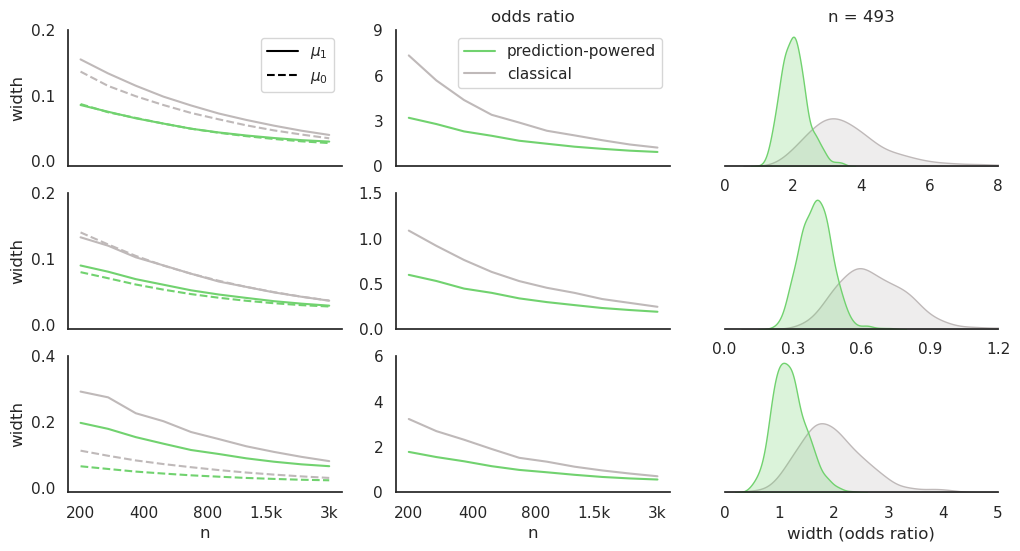

In [28]:
save = False

my_palette = sns.color_palette(["#71D26F", "#BFB9B9",], 2)
sns.set_theme(style="white", palette=my_palette)

ns = np.logspace(np.log10(200), np.log10(3000), num=10, base=10).astype(int)
n_hist = ns[3]
ptm_names = ['p', 'ub', 'ac']
fig, axs = plt.subplots(len(ptm_names), 3, figsize=(12, len(ptm_names) * 2))

ns_xticks = [200, 400, 800, 1500, 3000]
ns_xticklabels = [200, 400, 800, '1.5k', '3k']

hist_xlims = [[0, 8], [0, 1.2], [0, 5]]
hist_xticks = [np.arange(0, 9, 2), np.arange(0, 1.3, 0.3), np.arange(0, 6, 1)]

for p_idx, ptm in enumerate(ptm_names):
    
    # ===== left subplots =====
    
    pp_df = df.loc[(df.ptm == ptm) & (df.estimator == 'prediction-powered')]
    cl_df = df.loc[(df.ptm == ptm) & (df.estimator == 'classical')]
    
    # mu1
    wcl_n = np.array([cl_df.loc[cl_df.n == n]['mu1-width'].median()for n in ns])
    wpp_n = np.array([pp_df.loc[pp_df.n == n]['mu1-width'].median()for n in ns])
    axs[p_idx, 0].plot(ns, wpp_n)
    axs[p_idx, 0].plot(ns, wcl_n)
    
    # mu0
    wcl_n = np.array([cl_df.loc[cl_df.n == n]['mu0-width'].median()for n in ns])
    wpp_n = np.array([pp_df.loc[pp_df.n == n]['mu0-width'].median()for n in ns])
    axs[p_idx, 0].plot(ns, wpp_n, c=my_palette[0], linestyle='--')     
    axs[p_idx, 0].plot(ns, wcl_n, c=my_palette[1], linestyle='--')
    
    axs[p_idx, 0].set_xscale('log');
    axs[p_idx, 0].set_xticks([])
    axs[p_idx, 0].set_ylabel('width');
    sns.despine(ax=axs[p_idx, 0], top=True, right=True)
    
    axs[p_idx, 0].plot([0, 0], [0, 0], linestyle='-', c='k', label='$\mu_1$')
    axs[p_idx, 0].plot([0, 0], [0, 0], linestyle='--', c='k', label='$\mu_0$')
    
    # ===== middle subplots =====
    
    # odds ratio
    wcl_n = np.array([cl_df.loc[cl_df.n == n]['o-width'].median()for n in ns])
    wpp_n = np.array([pp_df.loc[pp_df.n == n]['o-width'].median()for n in ns])
    axs[p_idx, 1].plot(ns, wpp_n, label='prediction-powered')
    axs[p_idx, 1].plot(ns, wcl_n, label='classical')
    
    sns.despine(ax=axs[p_idx, 1], top=True, right=True)
    axs[p_idx, 1].set_xscale('log');
    axs[p_idx, 1].set_xticks([])
    
    # ===== right subplots
    
    hist_df = df.loc[(df.ptm == ptm) & (df.n == n_hist)]
    kde = sns.kdeplot(data=hist_df, x='o-width', hue='estimator', ax=axs[p_idx, 2], fill=True);
    sns.despine(ax=axs[p_idx, 2], top=True, right=True, left=True)
    axs[p_idx, 2].set_yticks([])
    axs[p_idx, 2].set_ylabel('')
    axs[p_idx, 2].set_xlim(hist_xlims[p_idx])
    axs[p_idx, 2].set_xticks(hist_xticks[p_idx])
    axs[p_idx, 2].set_xlabel('width (odds ratio)')
    kde.get_legend().remove()
    
for i in [0, 1]:
    axs[-1, i].set_xticks(ns_xticks)
    axs[-1, i].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axs[-1, i].set_xticklabels(ns_xticklabels)
    axs[-1, i].set_xlabel('n');
    axs[0, i].legend();
    axs[0, i].legend();
axs[0, 0].set_yticks([0, 0.1, 0.2])
axs[1, 0].set_yticks([0, 0.1, 0.2])
axs[2, 0].set_yticks([0, 0.2, 0.4])
axs[0, 1].set_yticks(np.arange(0, 10, 3))
axs[1, 1].set_yticks(np.arange(0, 1.7, 0.5))
axs[2, 1].set_yticks(np.arange(0, 7, 2))
axs[0, 1].set_title('odds ratio');
axs[0, 2].set_title('n = {}'.format(n_hist));

if save:
    plt.savefig('./figures/widths.pdf', dpi=300, bbox_inches='tight')
plt.show()